In [52]:
# Cell 1: Load CSV and pick 5 random sample rows (reshuffle every run)
from pathlib import Path
import random
import pandas as pd

CSV_PATH = Path('../data/8000/8000.csv')
DATA_ROOT = Path('../data/8000')
assert CSV_PATH.exists(), f'CSV not found: {CSV_PATH}'

df = pd.read_csv(CSV_PATH)
df = df[df['is_validate'] == True].copy()
df = df[df['image_name_gray'].notnull() | df['image_name'].notnull()].copy()

# Pick 5 random samples (reshuffle every run)
samples = df.sample(n=5) if len(df) >= 5 else df.copy()

# Resolve image path helper
def resolve_image_row(row):
    # Try several plausible locations and filename fields used in the CSV
    rel = row.get('image_name_gray') or row.get('image_name') or ''
    if not rel or str(rel).strip() == 'nan':
        return None
    # Normalize and strip any leading path separators so '/210/..' becomes relative
    rel = str(rel).strip()
    rel = rel.lstrip('/\\')
    # Some rows may contain nested folders. Try joining as relative to DATA_ROOT
    candidates = [
        DATA_ROOT / rel,
        DATA_ROOT / '210' / rel,
        DATA_ROOT / Path(rel).name,
    ]
    # Also try with common image extensions if missing
    stem = Path(rel).stem
    for ext in ['', '.jpg', '.jpeg', '.png']:
        candidates.append(DATA_ROOT / f'{stem}{ext}')
        candidates.append(DATA_ROOT / '210' / f'{stem}{ext}')
    for p in candidates:
        try:
            if p.exists():
                return p
        except Exception:
            # Path may be invalid on this machine; skip
            continue
    # Not found -> return first candidate (useful for diagnostics)
    return candidates[0] if candidates else None

image_paths = [resolve_image_row(r) for _, r in samples.iterrows()]
# Print diagnostics: show which samples mapped to existing files
for i, p in enumerate(image_paths):
    exists = p.exists() if (p is not None and hasattr(p, 'exists')) else False
    print(f'sample {i}:', p, 'FOUND' if exists else 'MISSING')


sample 0: ..\data\8000\210\2024-07-05\14\Lane1\2024-07-05_14-33-55-595_TRG-078061_Lane1_ฒร4411-THA_10.jpg FOUND
sample 1: ..\data\8000\210\2024-07-05\10\Lane1\2024-07-05_10-20-39-372_TRG-073680_Lane1_4กข4454-THA_10.jpg FOUND
sample 2: ..\data\8000\210\2024-07-05\15\Lane1\2024-07-05_15-05-33-916_TRG-078540_Lane1_ฌว3168-THA_10.jpg FOUND
sample 3: ..\data\8000\210\2024-07-05\15\Lane1\2024-07-05_15-27-07-398_TRG-078901_Lane1_4กก5403-THA_10.jpg FOUND
sample 4: ..\data\8000\210\2024-07-05\18\Lane1\2024-07-05_18-06-04-600_TRG-082032_Lane1_ฆก507-THA_65.jpg FOUND


C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3590 (\N{THAI CHARACTER KHO RAKHANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3585 (\N{THAI CHARACTER KO KAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


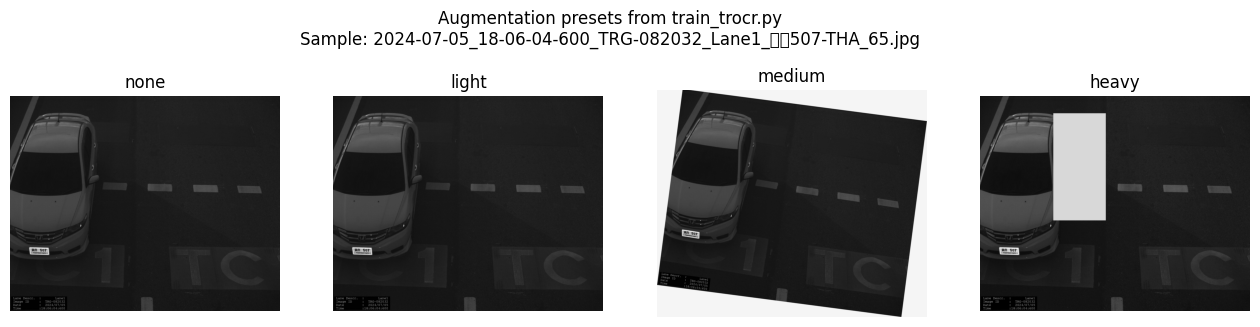

In [53]:
# Cell 2: Demonstrate augmentations (none, light, medium, heavy) from train_trocr
from PIL import Image
import matplotlib.pyplot as plt
import sys
import numpy as np
import random

# Add train_trocr.py directory to sys.path for import
from pathlib import Path
sys.path.insert(0, str(Path('../train').resolve()))
from train_trocr import build_augmentor

# Randomly pick a sample image that exists
valid_paths = [p for p in image_paths if p is not None and hasattr(p, 'exists') and p.exists()]
assert valid_paths, 'No valid image found in samples.'
img_path = random.choice(valid_paths)

img = Image.open(img_path).convert('RGB')

# Prepare augmentors
augment_names = ['none', 'light', 'medium', 'heavy']
augmentors = [build_augmentor(name) for name in augment_names]

# Apply augmentations
augmented_imgs = []
for aug in augmentors:
    if aug is None:
        augmented_imgs.append(img)
    else:
        augmented_imgs.append(aug(img))

# Plot results
plt.figure(figsize=(16, 4))
for i, (name, aug_img) in enumerate(zip(augment_names, augmented_imgs)):
    plt.subplot(1, 4, i+1)
    plt.imshow(aug_img)
    plt.title(name)
    plt.axis('off')
plt.suptitle(f'Augmentation presets from train_trocr.py\nSample: {img_path.name}')
plt.show()